# The Library

In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import re

In [3]:
import warnings
warnings.filterwarnings('ignore')

# The Necessary Files

In [4]:
current_dir = os.getcwd()
folder = '/data/results_international/'
result_file = 'adj_final_results.csv'
rubicology_file = 'all_games_RWC2023_fixed.csv'

# Expected score gap by elo gap/ relation between elo and score against or for?

In [6]:
result_df = pd.read_csv(current_dir+folder+result_file)
result_df['date'] = pd.to_datetime(result_df['date'])
result_df['point_gap'] = result_df.apply(lambda row: abs(row['Score A']-row['Score B']) , axis=1)
result_df.head(2)

Unnamed: 0       date    Team A   Team B  Score A  Score B  \
0           0 1882-12-16     Wales  England        0        2   
1           1 1883-01-08  Scotland    Wales        3        1   

                       Tourn Venue       City  Neut.  Country  elo_home  \
0  Home_Nations_Championship   NaN    Swansea   True      NaN    1000.0   
1  Home_Nations_Championship   NaN  Edinburgh   True      NaN    1000.0   

     elo_away  proba_home_win   elo_gap  outcome  point_gap  
0  1000.00000        0.500000   0.00000      0.0          2  
1   982.97151        0.524486  17.02849      1.0          2

In [7]:
#relationship between point gap and elo gap
result_positive_elo_gap = result_df
result_positive_elo_gap["elo_gap"] = result_positive_elo_gap["elo_gap"].abs()

[Text(0, 0.5, 'Point Gap'), Text(0.5, 0, 'Elo Gap')]

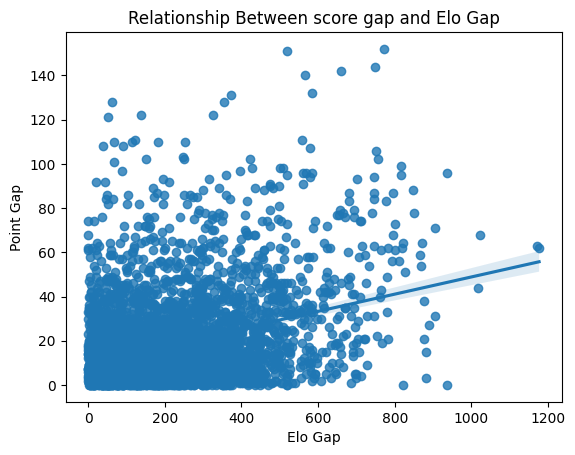

In [18]:
elo_gap_ax = sns.regplot(data=result_positive_elo_gap, y="point_gap", x="elo_gap")
elo_gap_ax.set(title='Relationship Between score gap and Elo Gap')
elo_gap_ax.set(ylabel='Point Gap', xlabel='Elo Gap')

In [54]:
excluded_tournaments = ['Rugby_World_Cup', 'Rugby_World_Cup_Pool_A', 'Rugby_World_Cup_Pool_B', 'Rugby_World_Cup_Pool_C', 'Rugby_World_Cup_Pool_D']

# Filter train data
result_positive_elo_gap_train = result_positive_elo_gap[
    (~result_positive_elo_gap['Tourn'].isin(excluded_tournaments)) & 
    (result_positive_elo_gap['date'].dt.year != 2023)
]

# Filter test data
result_positive_elo_gap_test = result_positive_elo_gap[
    (result_positive_elo_gap['Tourn'].isin(excluded_tournaments)) & 
    (result_positive_elo_gap['date'].dt.year == 2023)
]
#estimate point gap
X = np.array(result_positive_elo_gap_train['elo_gap']).reshape(-1,1)
y= np.array(result_positive_elo_gap_train['point_gap']).reshape(-1,1)
X_test = np.array(result_positive_elo_gap_test['elo_gap']).reshape(-1,1)
Y_test = np.array(result_positive_elo_gap_test['point_gap']).reshape(-1,1)
predict_score_gap = LinearRegression().fit(X, y)

In [56]:
#plot the elo gaps
sns.histplot(data=result_positive_elo_gap_train, x='elo_gap')

<Axes: xlabel='elo_gap', ylabel='Count'>

In [57]:
#evaluate models
predicted_y = predict_score_gap.predict(X)
predicted_y_test = predict_score_gap.predict(X_test)
mse = 0
for i in range(len(X)):
    mse += (predicted_y[i] - y[i])**2
    mse = mse/len(X)
print(f'mse: {mse}')
result_positive_elo_gap_train['predicted_gap'] = predicted_y
result_positive_elo_gap_test['predicted_gap'] = predicted_y_test

mse: [0.05464913]


# First exploration: Any upsets?

In [61]:
#Conditions on wins
condition_1 = result_positive_elo_gap_test['elo_gap']>200
condition_2 = (result_positive_elo_gap_test['proba_home_win']<0.5) & (result_positive_elo_gap_test['outcome']>0)
condition_3 = (result_positive_elo_gap_test['proba_home_win']>0.5) & (result_positive_elo_gap_test['outcome']<1)
#conditions on score 
condition_4 = result_positive_elo_gap_test['point_gap'] <result_positive_elo_gap_test['predicted_gap']-14
## we will look at score gap smaller than expectd
upsets = result_positive_elo_gap_test[((condition_1) & (condition_2 |condition_3 )) | (condition_1 & condition_4 ) ]
upsets.head(5)

Unnamed: 0       date   Team A       Team B  Score A  Score B  \
3961        3961 2023-09-08   France  New Zealand       27       13   
3981        3981 2023-09-23  Georgia     Portugal       18       18   
4000        4000 2023-10-08     Fiji     Portugal       23       24   
3995        3995 2023-10-07  England        Samoa       18       17   
3969        3969 2023-09-14   France      Uruguay       27       12   

                       Tourn                Venue               City  Neut.  \
3961  Rugby_World_Cup_Pool_A      Stade de France        Saint-Denis   True   
3981  Rugby_World_Cup_Pool_C  Stadium de Toulouse           Toulouse   True   
4000  Rugby_World_Cup_Pool_C  Stadium de Toulouse           Toulouse   True   
3995  Rugby_World_Cup_Pool_D  Stade Pierre-Mauroy  Villeneuve-d'Ascq   True   
3969  Rugby_World_Cup_Pool_A  Stade Pierre-Mauroy  Villeneuve-d'Ascq   True   

      Country     elo_home     elo_away  proba_home_win     elo_gap  outcome  \
3961      NaN  1663.837464  1867.245237        0.236691  203.407774      1.0   
3981      NaN  1402.623506  1094.632526        0.854823  307.990980      0.5   
4000      NaN  1447.860874  1084.001653        0.890372  363.859221      0.0   
3995      NaN  1628.516988  1190.722145        0.925542  437.794842      1.0   
3969      NaN  1722.493700  1032.485255        0.981513  690.008445      1.0   

      point_gap  predicted_gap  
3961         14      17.294593  
3981          0      20.933467  
4000          1      22.877350  
3995          1      25.449870  
3969         15      34.225404

# PCA Baby

In [ ]:
from sklearn import decomposition
from sklearn import datasets

In [91]:

rub_wc_df = pd.read_csv(current_dir+'/data/'+rubicology_file )
variables_start = list(rub_wc_df.columns)
variable_end = []
for variable in variables_start:
     if re.search(r'\sA(?!\S)', variable):
        new_variable = re.sub(r'\sA(?!\S)', ' ', variable)
        variable_end.append(new_variable.strip())
variable_a = ['Date', 'Game ID']
variable_b =  ['Date', 'Game ID']

for variable in variable_end:
    if 'Possession' not in variable:
        variable_a.append(f'{variable} A')
    else:
        one, two = variable.split('  - ')
        one = f'{one} A'
        variable = ' - '.join([one, two])
        variable_a.append(variable)

for variable in variable_end:
    if 'Possession' not in variable:
        variable_b.append(f'{variable} B')
    else:
        one, two = variable.split('  - ')
        one = f'{one} B'
        variable = ' - '.join([one, two])
        variable_b.append(variable)
        

rub_wc_df_a = rub_wc_df[variable_a ]
rub_wc_df_b = rub_wc_df[variable_b ]

rub_wc_df_a.columns = rub_wc_df_a.columns.str.replace(r'\sA(?!\S)', '', regex=True)
rub_wc_df_b.columns = rub_wc_df_b.columns.str.replace(r'\sB(?!\S)', '', regex=True)
split_df = pd.concat([rub_wc_df_a,rub_wc_df_b ])

Date  Game ID         Team  Score  Possession - Overall  \
0   28-Oct-2023    87881  New Zealand     11                    60   
1   27-Oct-2023    87880    Argentina     23                    53   
2   21-Oct-2023    87879      England     15                    56   
3   20-Oct-2023    87878    Argentina      6                    43   
4   15-Oct-2023    87877       France     28                    60   
..          ...      ...          ...    ...                   ...   
43   9-Sep-2023    87838    Argentina     10                    50   
44   9-Sep-2023    87837      Georgia     15                    43   
45   9-Sep-2023    87836      Romania      8                    33   
46   9-Sep-2023    87835      Namibia      8                    48   
47   8-Sep-2023    87834  New Zealand     13                    51   

    Possession - 1st half  Possession - 2nd half  Tries  Conversions  \
0                      63                     58      1            0   
1                      45                     59      2            2   
2                      52                     59      0            0   
3                      46                     40      0            0   
4                      59                     60      3            2   
..                    ...                    ...    ...          ...   
43                     46                     54      1            1   
44                     37                     49      2            1   
45                     43                     24      1            0   
46                     53                     44      1            0   
47                     56                     47      2            0   

    Penalties  ...  Rucks Successful  Total Rucks  Lineouts Successful  \
0           2  ...               115          120                   20   
1           3  ...               109          111                    8   
2           4  ...                67           68                    7   
3           2  ...               115          119                   10   
4           3  ...               103          108                   12   
..        ...  ...               ...          ...                  ...   
43          1  ...                77           83                   11   
44          1  ...                42           47                   11   
45          1  ...                30           33                    8   
46          1  ...                78           81                    9   
47          1  ...                75           80                   10   

    Lineouts Thrown  Scrums Successful  Scrums Total  \
0                22                  2             2   
1                 8                  6             7   
2                10                  3             7   
3                12                  4             4   
4                12                  5             9   
..              ...                ...           ...   
43               15                  1             2   
44               14                  6             6   
45               10                  8             9   
46               12                  6             6   
47               11                  5             7   

    Penalties Conceded Own Half  Penalties Conceded Opp Half  Yellow Cards  \
0                             4                            1             1   
1                             5                            2             0   
2                             4                            7             0   
3                             4                            6             0   
4                             2                            4             0   
..                          ...                          ...           ...   
43                            5                            8             1   
44                            7                            6             1   
45                            7          

In [ ]:
rub_wc_df = pd.read_csv(current_dir+'/data/'+rubicology_file )


In [ ]:
pca = decomposition.PCA()
pca.fit(X)